# Prepare environment

In [ ]:
!pip install -qU pip
!pip install -qU datasets[audio] transformers accelerate evaluate jiwer tensorboard

In [ ]:
import torch
import evaluate
from typing import Any, Dict, List, Union
from dataclasses import dataclass

from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    AutoModelForSpeechSeq2Seq,
    AutoProcessor,
    pipeline,
)
from datasets import load_dataset, DatasetDict, Audio

# General walktrough for finetune Whisper
Follow tutorial https://huggingface.co/blog/fine-tune-whisper

## Load dataset

In [ ]:
fleurs = DatasetDict()

fleurs["train"] = load_dataset("google/fleurs", "th_th", split="train", trust_remote_code=True)
fleurs["test"] = load_dataset("google/fleurs", "th_th", split="test", trust_remote_code=True)
print(fleurs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

fleurs.py:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

train.tar.gz:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/593M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/3.08M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/540k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 2602
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 1021
    })
})


## Inspect whisper token

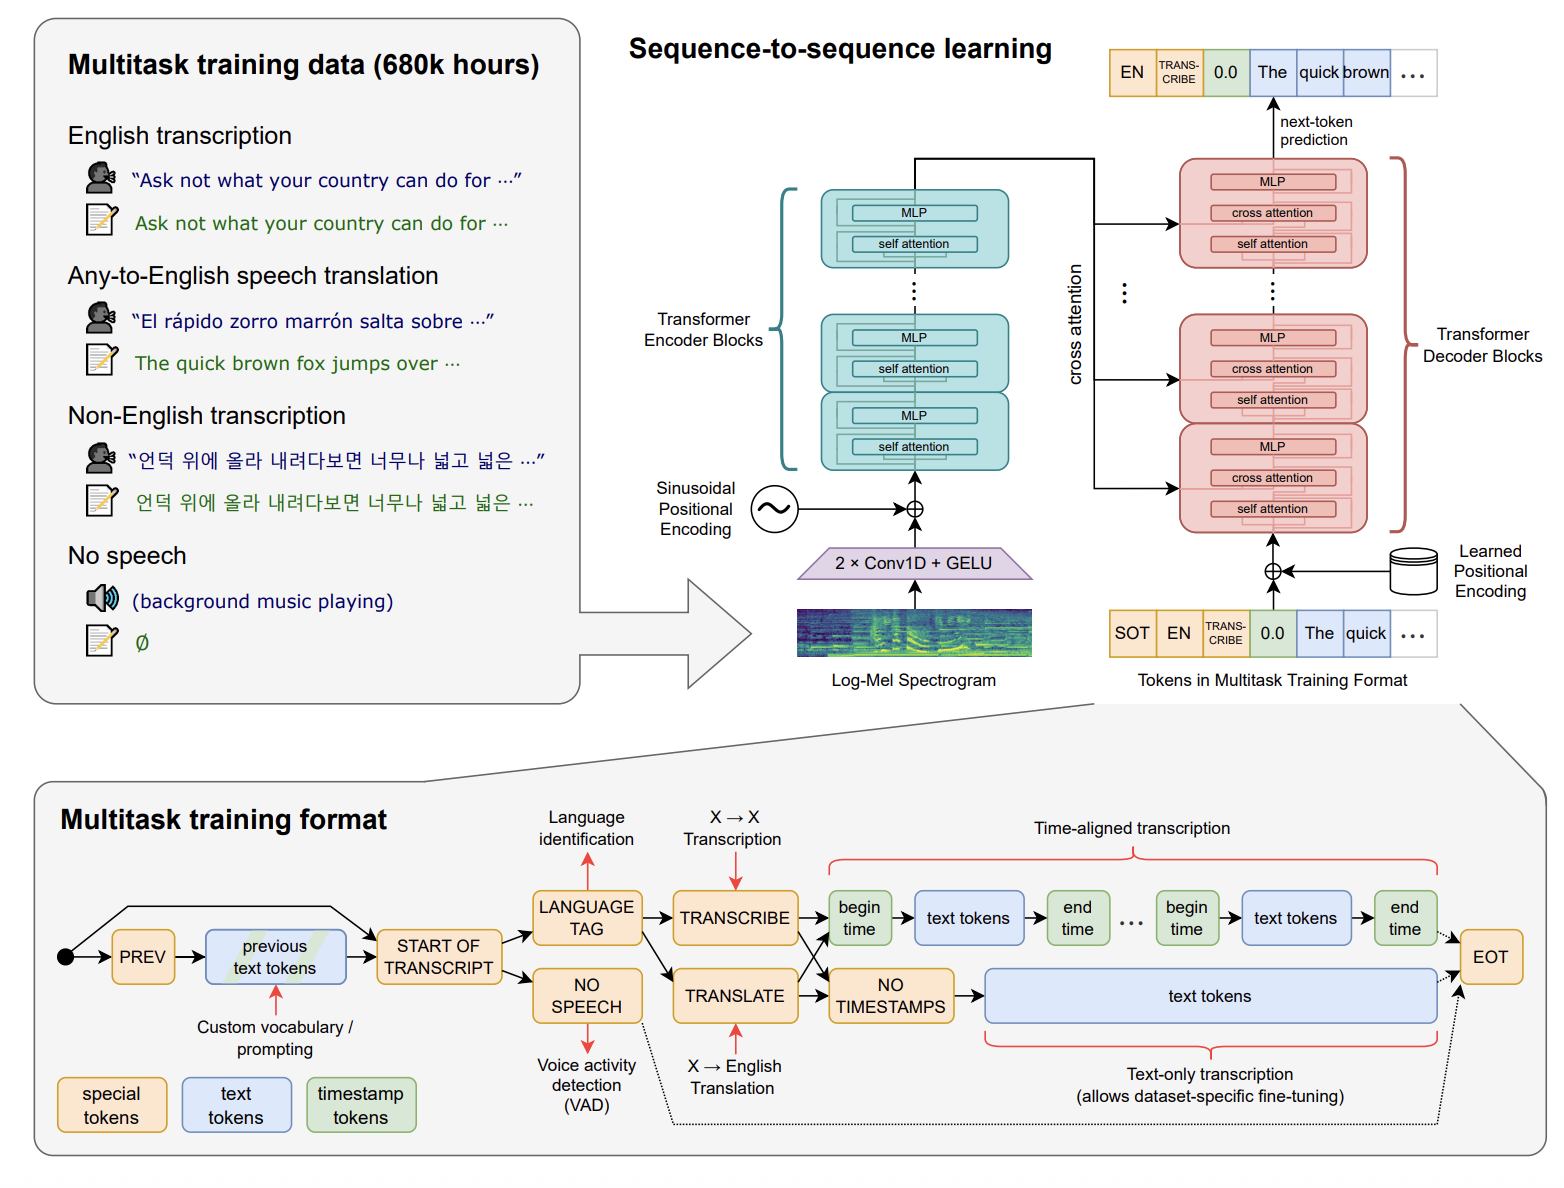

In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Thai", task="transcribe")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [ ]:
input_str = fleurs["train"][0]["transcription"]
labels = processor.tokenizer(input_str).input_ids
decoded_with_special = processor.tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = processor.tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")

Input:                 จะเป็นการดีที่สุดสำหรับนักท่องเที่ยวที่มีเวลาจำกัดที่จะไปใช้เวลาที่อื่น
Decoded w/ special:    <|startoftranscript|><|th|><|transcribe|><|notimestamps|>จะเป็นการดีที่สุดสำหรับนักท่องเที่ยวที่มีเวลาจำกัดที่จะไปใช้เวลาที่อื่น<|endoftext|>
Decoded w/out special: จะเป็นการดีที่สุดสำหรับนักท่องเที่ยวที่มีเวลาจำกัดที่จะไปใช้เวลาที่อื่น


## Prepare dataset for training

In [ ]:
fleurs = DatasetDict()

fleurs["train"] = load_dataset("google/fleurs", "th_th", split="train", trust_remote_code=True)
fleurs["test"] = load_dataset("google/fleurs", "th_th", split="test", trust_remote_code=True)
# Resample audio to 16kHz
fleurs = fleurs.cast_column("audio", Audio(sampling_rate=16000))
# Remove unused column
fleurs = fleurs.remove_columns(['id', 'num_samples', 'path', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'])
print(fleurs)

## Prepare function for training

In [ ]:
# Prepare data collator
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        audio_array = [feature["audio"]["array"] for feature in features]
        input_features = self.processor.feature_extractor(audio_array, sampling_rate=16000).input_features
        input_features = [{"input_features": input_feature} for input_feature in input_features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        transcription = [feature["transcription"] for feature in features]
        input_ids = self.processor.tokenizer(transcription).input_ids
        label_features = [{"input_ids": input_id} for input_id in input_ids]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

metric = evaluate.load("cer")
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Train the model

In [ ]:
# Load a pretrained checkpoint
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

model.generation_config.language = "thai"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Thai", task="transcribe")

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-th",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    remove_unused_columns=False,

)
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=fleurs["train"],
    eval_dataset=fleurs["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)
trainer.train()

In [ ]:
# Save model
SAVE_LAST_CHECKPOINT_DIR = "./whisper-small-th-chpt"
trainer.save_model(SAVE_LAST_CHECKPOINT_DIR)
processor.save_pretrained(SAVE_LAST_CHECKPOINT_DIR)

[]

## Use finetuned model

In [ ]:
!wget https://huggingface.co/datasets/Nexdata/Thai_Conversational_Speech_Data_by_Telephone/resolve/main/foo_301_00002_8k-10.wav

--2025-05-22 04:10:25--  https://huggingface.co/datasets/Nexdata/Thai_Conversational_Speech_Data_by_Telephone/resolve/main/foo_301_00002_8k-10.wav
Resolving huggingface.co (huggingface.co)... 18.239.50.49, 18.239.50.103, 18.239.50.16, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/83/37/83371066750f263f7ee12963e4e2a63127e62cf786d0b7f35ba7e39695128f41/56b74b84f167d4a74e69b5324b1be90ccc90fa778afc89ff4b7bc1bfa07fe891?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27foo_301_00002_8k-10.wav%3B+filename%3D%22foo_301_00002_8k-10.wav%22%3B&response-content-type=audio%2Fwave&Expires=1747890625&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Nzg5MDYyNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzgzLzM3LzgzMzcxMDY2NzUwZjI2M2Y3ZWUxMjk2M2U0ZTJhNjMxMjdlNjJjZjc4NmQwYjdmMzViYTdlMzk2OTUxMjhmNDEvNTZiNzRi

In [ ]:
model_id = "./whisper-small-th-chpt"


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

Device set to use cuda:0


In [ ]:
prediction = pipe("/content/foo_301_00002_8k-10.wav")
prediction

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


{'text': 'แต่ว่าไม่ใส่น้ำตาลเลย'}

# Trick & tips

## 1. Construct HF dataset from raw audio
Reference: https://huggingface.co/docs/datasets/en/audio_load#load-audio-data

```
Folder Structure:
custom_audio_dataset/
├── <audio folder>/
│   └── <audio files copied here>
└── metadata.jsonl
```

In [ ]:
!gdown 16cTXVwT2LVVHRnGzRF_0RkLSkso_plG7

Downloading...
From: https://drive.google.com/uc?id=16cTXVwT2LVVHRnGzRF_0RkLSkso_plG7
To: /content/cv-corpus-21.0-delta-2025-03-14-th.tar.gz
100% 14.8M/14.8M [00:00<00:00, 32.8MB/s]


In [ ]:
!tar -xf /content/cv-corpus-21.0-delta-2025-03-14-th.tar.gz

In [ ]:
import pandas as pd

df_other = pd.read_csv("/content/cv-corpus-21.0-delta-2025-03-14/th/other.tsv", sep="\t")
df_other

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,a25378653ef3c6242a5cb0764adb95e2a529fe6940dfc1...,common_voice_th_41916598.mp3,00eef11948e6565f6ba9f638b729517cb183e0a9e34747...,ไม่ใส่ผงชูรส,NaN,0,0,NaN,NaN,ภาคกลาง,NaN,th,NaN
1,a25378653ef3c6242a5cb0764adb95e2a529fe6940dfc1...,common_voice_th_41916599.mp3,00ac4fb1c33eb467072e594e4c8b5296266dd7ad12954d...,พวกหมูและวัววิ่งไปทุกที่,NaN,0,0,NaN,NaN,ภาคกลาง,NaN,th,NaN
2,a25378653ef3c6242a5cb0764adb95e2a529fe6940dfc1...,common_voice_th_41916600.mp3,00f9e81794aa9e88ac9d4f81afb5a110480703333ea62b...,ไม่น่าเชื่อว่าเดี๋ยวนี้เผาซีดีแผ่นนึง ใช้เวลาแ...,NaN,0,0,NaN,NaN,ภาคกลาง,NaN,th,NaN
3,a25378653ef3c6242a5cb0764adb95e2a529fe6940dfc1...,common_voice_th_41916602.mp3,0164cb6f8ddbfdb69866570c15ff3921300d35d7c3cd94...,ข่าวโควิดเยอะจนคนอาจลืมสนใจประเด็นชายแดนใต้,NaN,0,0,NaN,NaN,ภาคกลาง,NaN,th,NaN
4,a25378653ef3c6242a5cb0764adb95e2a529fe6940dfc1...,common_voice_th_41916603.mp3,0058dc6bc011f267e348fdecdabb34b6a9f68fbc08bbc7...,ทุกวันนี่ ขาไก่เป็นเมนูที่หาทานได้ยาก,NaN,0,0,NaN,NaN,ภาคกลาง,NaN,th,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2eeefcd1dcd93c9d57e14ffc1e741ce7746e0d51f1bc96...,common_voice_th_42693716.mp3,00cf9336d2165c0f8bb05453c5913fbb57f0df25313464...,ปัจจุบันกาลที่สมบูรณ์ หอศิลป พีระศรี,NaN,0,0,twenties,NaN,"Thai,ไทย,Thailand",NaN,th,NaN
81,2eeefcd1dcd93c9d57e14ffc1e741ce7746e0d51f1bc96...,common_voice_th_42693717.mp3,0070c8149253328f3916de314d130e73c491258ec5c086...,เกมเดียวที่เล่นจริงจังคือ,NaN,0,0,twenties,NaN,"Thai,ไทย,Thailand",NaN,th,NaN
82,2eeefcd1dcd93c9d57e14ffc1e741ce7746e0d51f1bc96...,common_voice_th_42693718.mp3,00ced845619e419ab3ad92ee0a2a09ec67bed7b7fc2b73...,ตอบถูกแถมแว่นกันแดดกับยาดมและจุกนมเด็กด้วยปะฮะ,NaN,0,0,twenties,NaN,"Thai,ไทย,Thailand",NaN,th,NaN
83,2eeefcd1dcd93c9d57e14ffc1e741ce7746e0d51f1bc96...,common_voice_th_42693719.mp3,0098b89d40c3afe7dc6fb19a76d62761984c2fe5cd7b6c...,ตื่นเช้านะเนี่ย ไม่ได้เห็นกันนาน,NaN,0,0,twenties,NaN,"Thai,ไทย,Thailand",NaN,th,NaN


In [ ]:
import os
import json
from pathlib import Path
import shutil

SRC_AUDIO_DIR = "/content/cv-corpus-21.0-delta-2025-03-14/th/clips"
HF_DATASET_DIR = "./custom_audio_dataset"

METADATA_FILE = os.path.join(HF_DATASET_DIR, f"metadata.jsonl")
HF_DATASET_AUDIO_DIR = os.path.join(HF_DATASET_DIR, "audio")

os.makedirs(HF_DATASET_DIR, exist_ok=True)
os.makedirs(HF_DATASET_AUDIO_DIR, exist_ok=True)

with open(METADATA_FILE, "w") as f:
  pass


for row in df_other.to_dict("records"):
  shutil.copy(os.path.join(SRC_AUDIO_DIR, row["path"]), HF_DATASET_AUDIO_DIR)
  metadata = {
      "file_name": f'audio/{row["path"]}',
      "sentence": row["sentence"],
      "client_id": row["client_id"],
      "sentence_id": row["sentence_id"],
  }
  with open(METADATA_FILE, "a") as f:
    f.write(json.dumps(metadata, ensure_ascii=False))
    f.write("\n")



In [ ]:
from datasets import load_dataset

dataset = load_dataset("audiofolder", data_dir=HF_DATASET_DIR)
dataset

Resolving data files:   0%|          | 0/86 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'client_id', 'sentence_id'],
        num_rows: 85
    })
})

In [ ]:
dataset['train'][0]

{'audio': {'path': '/content/custom_audio_dataset/audio/common_voice_th_41916598.mp3',
  'array': array([ 0.00000000e+00, -1.44033136e-12, -2.52378934e-12, ...,
         -6.76240597e-05, -4.16511612e-05,  4.35552211e-05]),
  'sampling_rate': 32000},
 'sentence': 'ไม่ใส่ผงชูรส',
 'client_id': 'a25378653ef3c6242a5cb0764adb95e2a529fe6940dfc1a12059210e06387189b17032140c41983385156a3130896e03303cedcd4e6e53d9fb523a3fc2b69c62',
 'sentence_id': '00eef11948e6565f6ba9f638b729517cb183e0a9e347476fa5291fb3f5fc5c57'}

## 2. Close CER/WER evaluation in training pipeline
Using CER/WER for evaluation may waste training time.